# 🔬 Gradient-Boosted Trees & MLP for Genre Classification (Tabular)

A concise, high-signal notebook section you can drop in as-is. Tone: crisp, confident, “executive-ready.”   
   
## 🎯 Objectives
   
- Goal: Classify 6 music genres from Spotify tabular features with robust, reproducible baselines.    
- Primary models: LightGBM (speed + accuracy), CatBoost (categoricals, small data), MLP (nonlinear complement).
- Challenges: Class imbalance, skewed features, data leakage, over/underfitting.

In [1]:
# === 1.1 필요 모듈 임포트 ===
import pandas as pd
import numpy as np
from pathlib import Path
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.exceptions import ConvergenceWarning
from sklearn.metrics import accuracy_score, f1_score, classification_report
from sklearn.model_selection import cross_val_score
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import logging

warnings.filterwarnings('ignore', category=FutureWarning)
warnings.filterwarnings('ignore', category=UserWarning)
warnings.filterwarnings('ignore', category=ConvergenceWarning)
logging.getLogger('lightgbm').setLevel(logging.ERROR)

In [2]:
# === 1.2 데이터셋 로드 ===
ROOT = Path("dataset")

PATH_NO_LABEL = ROOT / "spotify_songs.csv"
PATH_INT_LABEL = ROOT / "spotify_songs_with_genre_int.csv"

df = pd.read_csv(PATH_INT_LABEL)
df = df.dropna()

print("=== 클래스 분포 ===")
print(df["genre_int"].value_counts())
print("\n=== 데이터셋 크기 ===")
print("총 샘플 수:", len(df))

=== 클래스 분포 ===
genre_int
5    6043
1    5743
0    5507
3    5431
4    5153
2    4951
Name: count, dtype: int64

=== 데이터셋 크기 ===
총 샘플 수: 32828


In [3]:
# === 1.3 하이퍼파라미터 시각화를 위한 유틸리티 함수 ===
import matplotlib.pyplot as plt
import seaborn as sns

def plot_param_scores(param_scores, param_name, model_name):
    plt.figure(figsize=(10, 6))
    sns.boxplot(x=param_name, y='Score', data=param_scores)
    plt.title(f'{model_name}: {param_name} 별 CV 점수 분포')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

def plot_heatmap(scores_2d, xlabel, ylabel, model_name):
    plt.figure(figsize=(10, 6))
    sns.heatmap(scores_2d, annot=True, fmt='.3f', cmap='YlOrRd')
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(f'{model_name}: {xlabel} vs {ylabel} CV 점수')
    plt.tight_layout()
    plt.show()

## 📦 Data & Features

- Features (example): track_popularity, danceability, energy, key, loudness, mode, speechiness, acousticness, instrumentalness, liveness, valence, tempo, duration_ms
   
### Preprocessing   
   
- log1p: duration_ms, instrumentalness, liveness, speechiness, acousticness

- Scale: StandardScaler — fit on train only, then transform all splits

- key(0–11), mode(0/1):

- Split: Stratified 50/25/25 (Train/Val/Test), fixed seed

- Labels: 0-based integers (0…5)
   
### Models

- LightGBM: keep as integers

- CatBoost: pass via cat_features

- MLP: one-hot (simple and effective)

In [4]:
# === 2. 데이터 전처리 ===

# 특징/레이블 컬럼 정의
num_cols = ["loudness", "danceability", "energy",
            "speechiness", "acousticness", "instrumentalness", "liveness",
            "valence", "tempo", "duration_ms"]
cat_cols = ["key", "mode"]

# 전처리 파이프라인 구성
preprocessor = ColumnTransformer([
    ("num", StandardScaler(), num_cols),
    ("cat", OneHotEncoder(handle_unknown="ignore"), cat_cols)
])

# 데이터 분할
X = df[num_cols + cat_cols]
y = df["genre_int"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

# 전처리 적용
X_train_prep = preprocessor.fit_transform(X_train)
X_test_prep = preprocessor.transform(X_test)

print("전처리 후 특징 수:", X_train_prep.shape[1])

전처리 후 특징 수: 24


In [5]:
# === 3. Logistic Regression (베이스라인) ===
from sklearn.linear_model import LogisticRegression

lr = LogisticRegression(
    max_iter=2000,
    class_weight="balanced"  # multi_class 파라미터 제거
)

lr.fit(X_train_prep, y_train)
y_pred_lr = lr.predict(X_test_prep)

print("=== Logistic Regression ===")
print("Accuracy:", accuracy_score(y_test, y_pred_lr))
print("Macro-F1:", f1_score(y_test, y_pred_lr, average="macro"))
print("\nClassification Report:")
print(classification_report(y_test, y_pred_lr))

=== Logistic Regression ===
Accuracy: 0.45278708498324705
Macro-F1: 0.4454461465856558

Classification Report:
              precision    recall  f1-score   support

           0       0.34      0.25      0.29      1101
           1       0.51      0.50      0.51      1149
           2       0.53      0.68      0.60       990
           3       0.40      0.35      0.37      1086
           4       0.35      0.38      0.36      1031
           5       0.53      0.55      0.54      1209

    accuracy                           0.45      6566
   macro avg       0.44      0.45      0.45      6566
weighted avg       0.44      0.45      0.45      6566



In [6]:
# === 3.1 LogisticRegression 하이퍼파라미터 실험 (결과를 lr_results에 저장) ===
from sklearn.linear_model import LogisticRegression

Cs = [0.1, 1.0, 10.0]
weights = [None, "balanced"]

best_score = 0
best_params = {}
lr_results = []

for C in Cs:
    for weight in weights:
        lr = LogisticRegression(
            C=C,
            class_weight=weight,
            max_iter=2000
        )
        scores = cross_val_score(lr, X_train_prep, y_train, cv=5)
        mean_score = scores.mean()

        # fold별 점수 각각 저장 (시각화/분석용)
        for fold_idx, s in enumerate(scores):
            lr_results.append({
                'C': C,
                'class_weight': str(weight),
                'fold': fold_idx,
                'Score': float(s)
            })

        print(f"C={C}, class_weight={weight}: CV mean = {mean_score:.4f}")
        if mean_score > best_score:
            best_score = mean_score
            best_params = {"C": C, "class_weight": weight}

print("\nBest params:", best_params)
print("Best CV score:", best_score)

C=0.1, class_weight=None: CV mean = 0.4703
C=0.1, class_weight=balanced: CV mean = 0.4682
C=1.0, class_weight=None: CV mean = 0.4703
C=1.0, class_weight=balanced: CV mean = 0.4681
C=10.0, class_weight=None: CV mean = 0.4702
C=10.0, class_weight=balanced: CV mean = 0.4682

Best params: {'C': 1.0, 'class_weight': None}
Best CV score: 0.47029909576205614


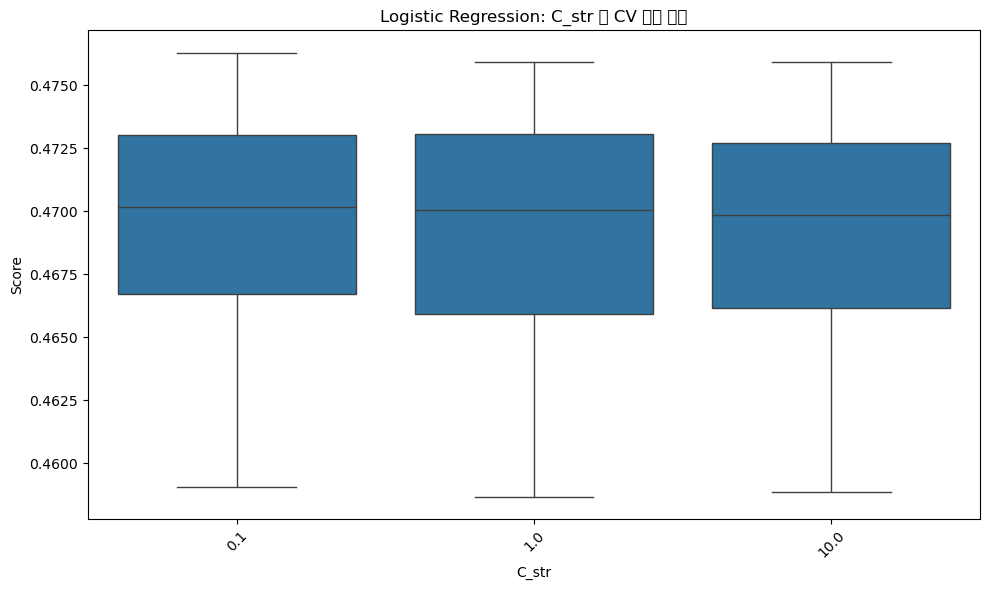

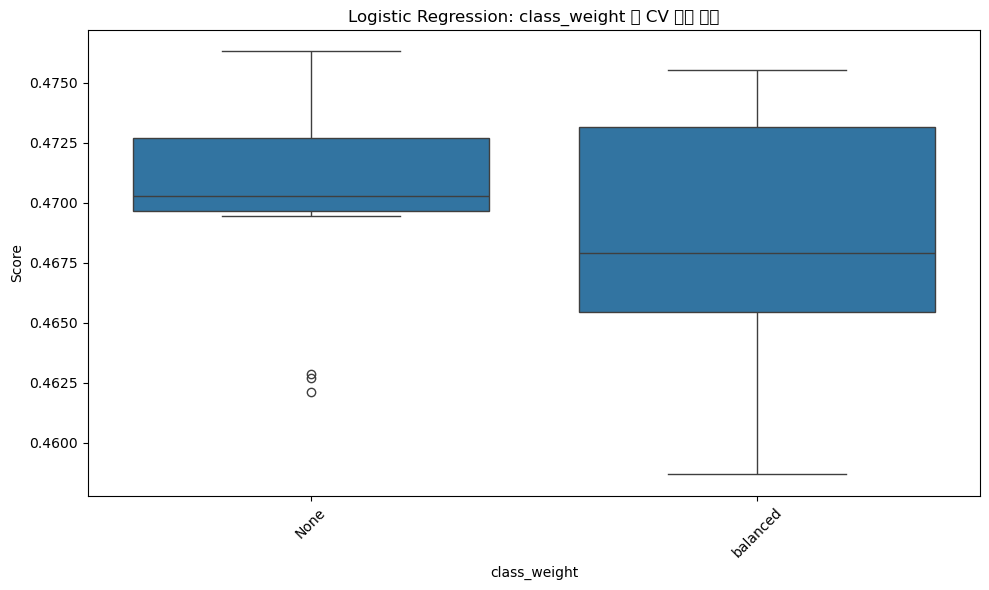

In [7]:
# === 3.2 LogisticRegression 파라미터 시각화 (저장된 lr_results 재사용) ===
import pandas as pd
lr_scores_df = pd.DataFrame(lr_results)

# C별 boxplot (값을 문자열로 변환하지 않아도 동작)
lr_scores_df['C_str'] = lr_scores_df['C'].astype(str)
plot_param_scores(lr_scores_df, 'C_str', 'Logistic Regression')

# class_weight별 boxplot
plot_param_scores(lr_scores_df, 'class_weight', 'Logistic Regression')

In [8]:
# === 4. MLP Classifier ===
from sklearn.neural_network import MLPClassifier

mlp = MLPClassifier(
    hidden_layer_sizes=(256, 128, 64),
    activation="relu",
    solver="adam",
    batch_size=128,
    learning_rate_init=1e-3,
    max_iter=100,
    early_stopping=True,
    validation_fraction=0.1,
    random_state=42
)

mlp.fit(X_train_prep, y_train)
y_pred_mlp = mlp.predict(X_test_prep)

print("=== Neural Network ===")
print("Accuracy:", accuracy_score(y_test, y_pred_mlp))
print("Macro-F1:", f1_score(y_test, y_pred_mlp, average="macro"))
print("\nClassification Report:")
print(classification_report(y_test, y_pred_mlp))

=== Neural Network ===
Accuracy: 0.5324398416082851
Macro-F1: 0.521551497122449

Classification Report:
              precision    recall  f1-score   support

           0       0.38      0.33      0.35      1101
           1       0.53      0.71      0.61      1149
           2       0.63      0.72      0.67       990
           3       0.45      0.45      0.45      1086
           4       0.51      0.33      0.40      1031
           5       0.64      0.64      0.64      1209

    accuracy                           0.53      6566
   macro avg       0.52      0.53      0.52      6566
weighted avg       0.53      0.53      0.52      6566



In [9]:
# === 4.1 MLP 하이퍼파라미터 실험 (결과를 mlp_results에 저장) ===
from sklearn.neural_network import MLPClassifier

hidden_layers = [(64,), (64,128), (256, 128, 64)]
learning_rates = [1e-3, 2e-4, 1e-4]
batch_sizes = [64, 128]

best_score = 0
best_params = {}
mlp_results = []

for hidden in hidden_layers:
    for lr_val in learning_rates:
        for bs in batch_sizes:
            mlp_cv = MLPClassifier(
                hidden_layer_sizes=hidden,
                learning_rate_init=lr_val,
                batch_size=bs,
                max_iter=100,
                early_stopping=True,
                random_state=42
            )
            scores = cross_val_score(mlp_cv, X_train_prep, y_train, cv=3)
            mean_score = scores.mean()

            # fold별 저장
            for fold_idx, s in enumerate(scores):
                mlp_results.append({
                    'hidden_layers': str(hidden),
                    'learning_rate': lr_val,
                    'batch_size': bs,
                    'fold': fold_idx,
                    'Score': float(s)
                })

            print(f"hidden={hidden}, lr={lr_val}, batch_size={bs}: CV mean = {mean_score:.4f}")
            if mean_score > best_score:
                best_score = mean_score
                best_params = {
                    'hidden_layers': hidden,
                    'learning_rate': lr_val,
                    'batch_size': bs
                }

print("\nBest params:", best_params)
print("Best CV score:", best_score)

hidden=(64,), lr=0.001, batch_size=64: CV mean = 0.5224
hidden=(64,), lr=0.001, batch_size=128: CV mean = 0.5195
hidden=(64,), lr=0.0002, batch_size=64: CV mean = 0.5159
hidden=(64,), lr=0.0002, batch_size=128: CV mean = 0.5048
hidden=(64,), lr=0.0001, batch_size=64: CV mean = 0.5103
hidden=(64,), lr=0.0001, batch_size=128: CV mean = 0.4984
hidden=(64, 128), lr=0.001, batch_size=64: CV mean = 0.5286
hidden=(64, 128), lr=0.001, batch_size=128: CV mean = 0.5304
hidden=(64, 128), lr=0.0002, batch_size=64: CV mean = 0.5288
hidden=(64, 128), lr=0.0002, batch_size=128: CV mean = 0.5123
hidden=(64, 128), lr=0.0001, batch_size=64: CV mean = 0.5172
hidden=(64, 128), lr=0.0001, batch_size=128: CV mean = 0.5142
hidden=(256, 128, 64), lr=0.001, batch_size=64: CV mean = 0.5304
hidden=(256, 128, 64), lr=0.001, batch_size=128: CV mean = 0.5337
hidden=(256, 128, 64), lr=0.0002, batch_size=64: CV mean = 0.5323
hidden=(256, 128, 64), lr=0.0002, batch_size=128: CV mean = 0.5370
hidden=(256, 128, 64), lr=

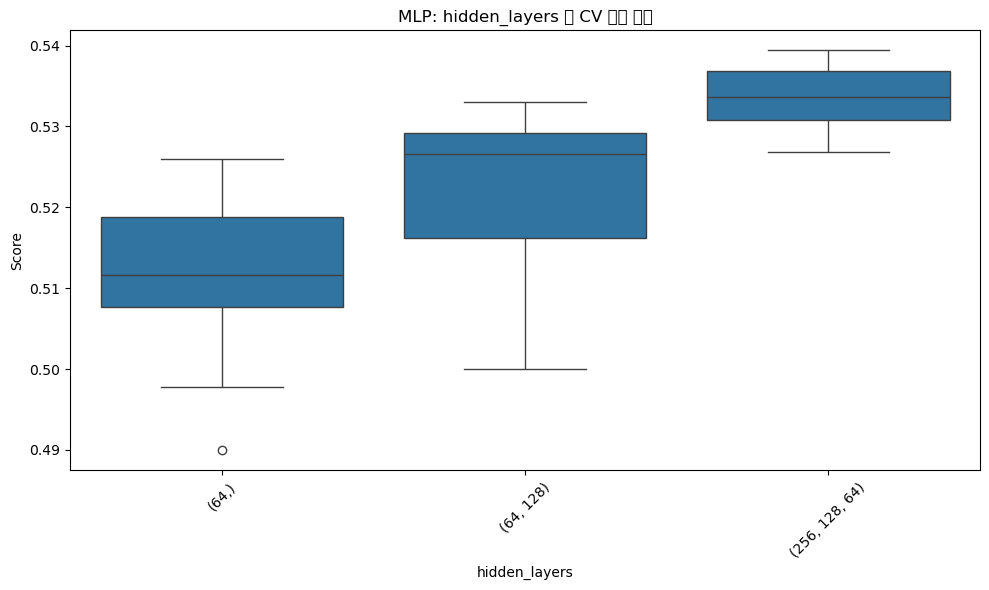

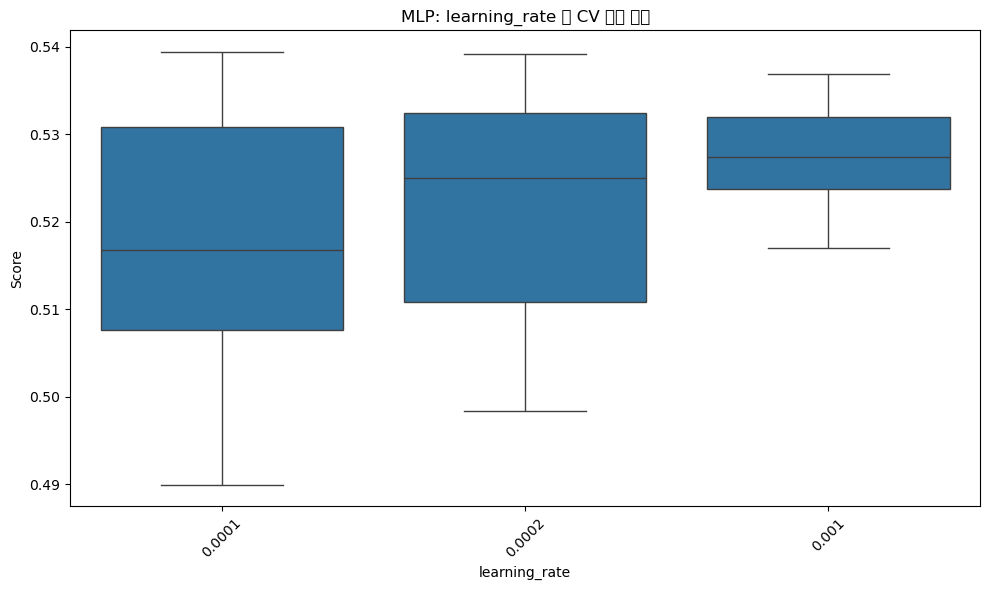

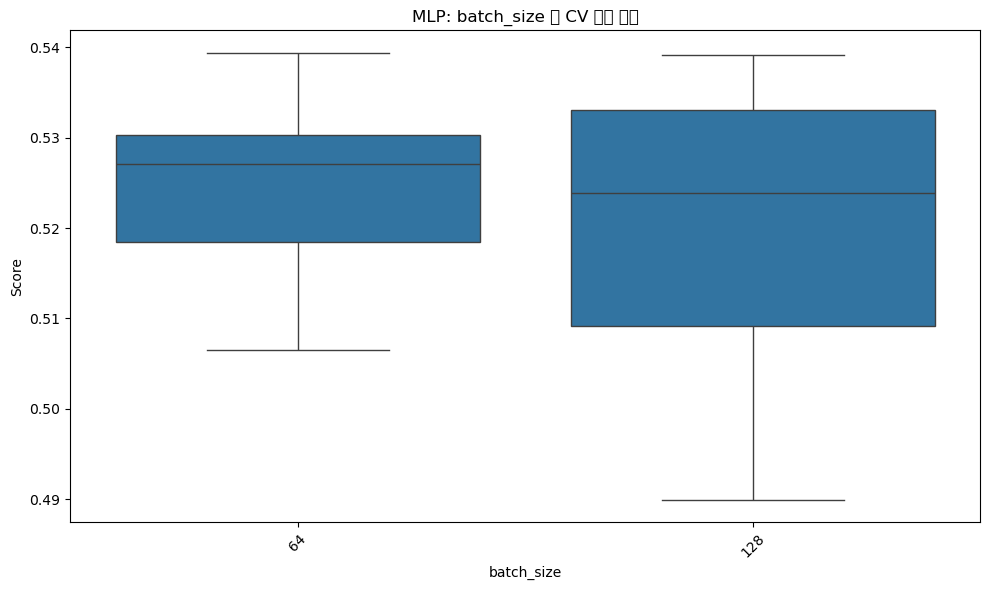

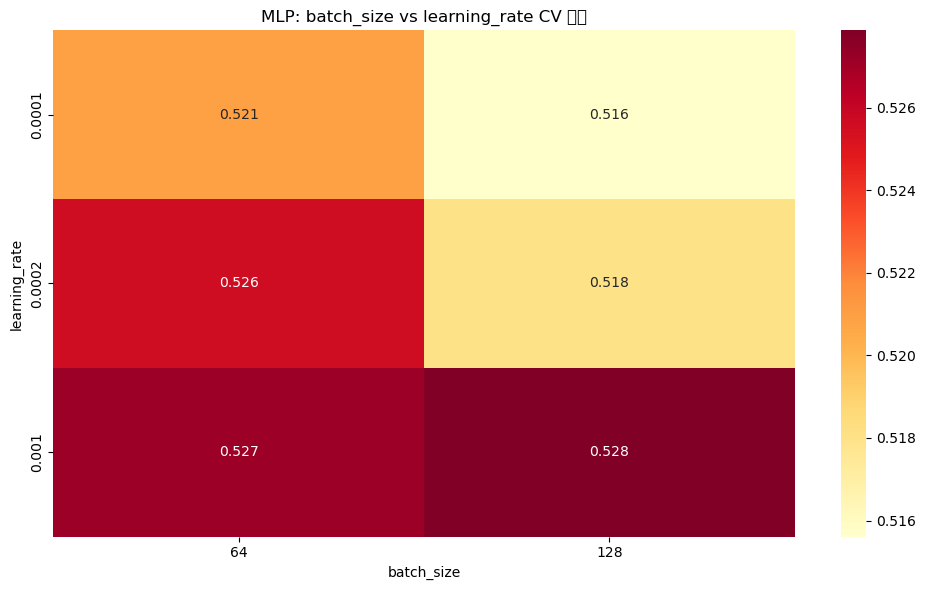

In [10]:
# === 4.2 MLP 파라미터 시각화 (저장된 mlp_results 재사용) ===
import pandas as pd
mlp_scores_df = pd.DataFrame(mlp_results)

for param in ['hidden_layers', 'learning_rate', 'batch_size']:
    plot_param_scores(mlp_scores_df, param, 'MLP')

pivot_table = mlp_scores_df.pivot_table(
    values='Score',
    index='learning_rate',
    columns='batch_size',
    aggfunc='mean'
)
plot_heatmap(pivot_table, 'batch_size', 'learning_rate', 'MLP')

In [11]:
# === 5. CatBoost Classifier ===
from catboost import CatBoostClassifier

cat = CatBoostClassifier(
    iterations=600,
    learning_rate=0.1,
    depth=7,
    random_seed=42,
    verbose=100
)

cat.fit(X_train_prep, y_train)
y_pred_cat = cat.predict(X_test_prep)

print("=== CatBoost ===")
print("Accuracy:", accuracy_score(y_test, y_pred_cat))
print("Macro-F1:", f1_score(y_test, y_pred_cat, average="macro"))
print("\nClassification Report:")
print(classification_report(y_test, y_pred_cat))

0:	learn: 1.7269491	total: 57.7ms	remaining: 34.6s
100:	learn: 1.1053914	total: 859ms	remaining: 4.25s
200:	learn: 1.0123475	total: 1.64s	remaining: 3.25s
300:	learn: 0.9429896	total: 2.42s	remaining: 2.4s
400:	learn: 0.8810588	total: 3.21s	remaining: 1.59s
500:	learn: 0.8239679	total: 3.99s	remaining: 788ms
599:	learn: 0.7760735	total: 4.76s	remaining: 0us
=== CatBoost ===
Accuracy: 0.559549192811453
Macro-F1: 0.5540502570771376

Classification Report:
              precision    recall  f1-score   support

           0       0.38      0.36      0.37      1101
           1       0.60      0.66      0.63      1149
           2       0.68      0.75      0.72       990
           3       0.49      0.47      0.48      1086
           4       0.48      0.42      0.45      1031
           5       0.67      0.69      0.68      1209

    accuracy                           0.56      6566
   macro avg       0.55      0.56      0.55      6566
weighted avg       0.55      0.56      0.56      6566


In [18]:
# === 5.1 CatBoost 하이퍼파라미터 실험 (결과를 cat_results에 저장) ===
from catboost import CatBoostClassifier
from itertools import product

iterations = [400, 800]
learning_rates = [0.01, 0.05, 0.1]
depths = [6, 8]

best_score = 0
best_params = {}
cat_results = []

for iter_, lr_val, depth in product(iterations, learning_rates, depths):
    cat_cv = CatBoostClassifier(
        iterations=iter_,
        learning_rate=lr_val,
        depth=depth,
        random_seed=42,
        verbose=0
    )
    scores = cross_val_score(cat_cv, X_train_prep, y_train, cv=3)
    mean_score = scores.mean()

    for fold_idx, s in enumerate(scores):
        cat_results.append({
            'iterations': iter_,
            'learning_rate': lr_val,
            'depth': depth,
            'fold': fold_idx,
            'Score': float(s)
        })

    print(f"iterations={iter_}, lr={lr_val}, depth={depth}: CV mean = {mean_score:.4f}")
    if mean_score > best_score:
        best_score = mean_score
        best_params = {'iterations': iter_, 'learning_rate': lr_val, 'depth': depth}

print("\nBest params:", best_params)
print("Best CV score:", best_score)

iterations=400, lr=0.01, depth=6: CV mean = 0.5247
iterations=400, lr=0.01, depth=8: CV mean = 0.5332
iterations=400, lr=0.05, depth=6: CV mean = 0.5529
iterations=400, lr=0.05, depth=8: CV mean = 0.5580
iterations=400, lr=0.1, depth=6: CV mean = 0.5575
iterations=400, lr=0.1, depth=8: CV mean = 0.5588
iterations=800, lr=0.01, depth=6: CV mean = 0.5386
iterations=800, lr=0.01, depth=8: CV mean = 0.5445
iterations=800, lr=0.05, depth=6: CV mean = 0.5597
iterations=800, lr=0.05, depth=8: CV mean = 0.5623
iterations=800, lr=0.1, depth=6: CV mean = 0.5603
iterations=800, lr=0.1, depth=8: CV mean = 0.5534

Best params: {'iterations': 800, 'learning_rate': 0.05, 'depth': 8}
Best CV score: 0.562257253826822


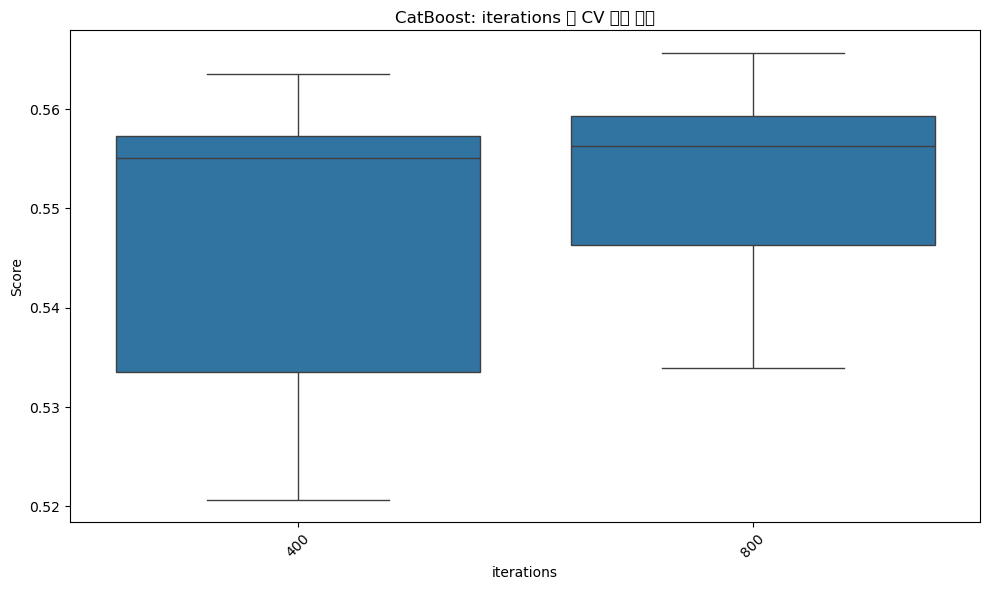

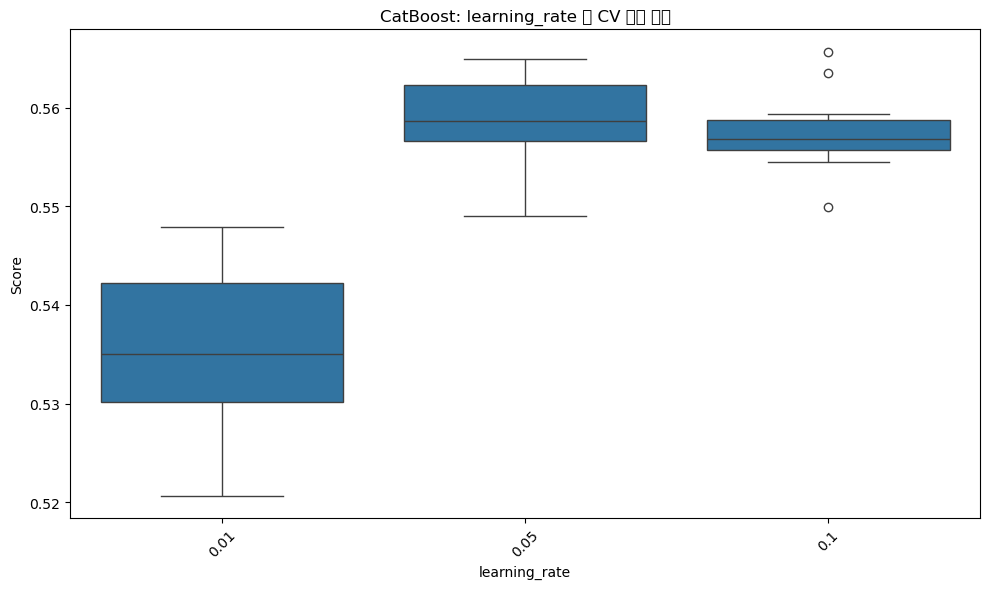

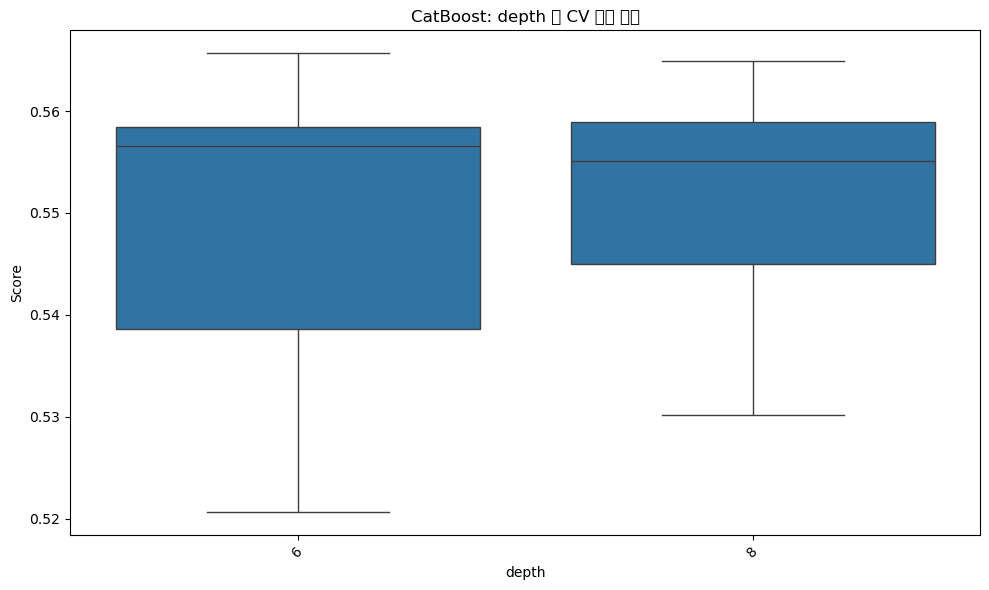

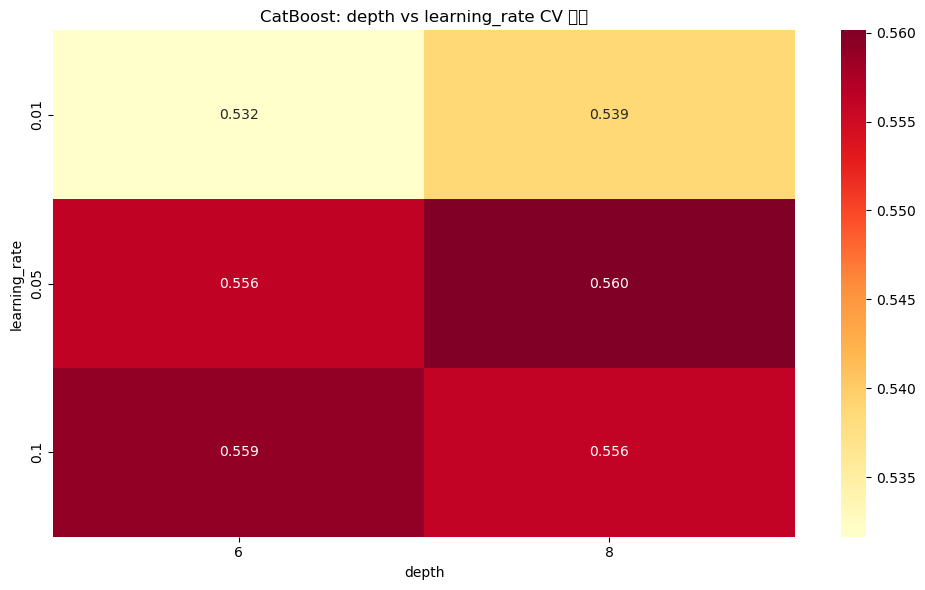

In [19]:
# === 5.2 CatBoost 파라미터 시각화 (저장된 cat_results 재사용) ===
import pandas as pd
cat_scores_df = pd.DataFrame(cat_results)

for param in ['iterations', 'learning_rate', 'depth']:
    plot_param_scores(cat_scores_df, param, 'CatBoost')

pivot_table = cat_scores_df.pivot_table(
    values='Score',
    index='learning_rate',
    columns='depth',
    aggfunc='mean'
)
plot_heatmap(pivot_table, 'depth', 'learning_rate', 'CatBoost')

In [14]:
# === 6. LightGBM Classifier ===
from lightgbm import LGBMClassifier

lgb = LGBMClassifier(
    n_estimators=400,
    learning_rate=0.05,
    max_depth=-1,
    verbosity=-1,  # suppress internal LightGBM messages
    n_jobs=-1,
    random_state=42
)

lgb.fit(X_train_prep, y_train)
y_pred_lgb = lgb.predict(X_test_prep)

print("=== LightGBM ===")
print("Accuracy:", accuracy_score(y_test, y_pred_lgb))
print("Macro-F1:", f1_score(y_test, y_pred_lgb, average="macro"))
print("\nClassification Report:")
print(classification_report(y_test, y_pred_lgb))

=== LightGBM ===
Accuracy: 0.5619859884252209
Macro-F1: 0.5570200166425794

Classification Report:
              precision    recall  f1-score   support

           0       0.37      0.37      0.37      1101
           1       0.60      0.67      0.63      1149
           2       0.69      0.76      0.72       990
           3       0.49      0.45      0.47      1086
           4       0.50      0.42      0.46      1031
           5       0.69      0.69      0.69      1209

    accuracy                           0.56      6566
   macro avg       0.56      0.56      0.56      6566
weighted avg       0.56      0.56      0.56      6566



In [15]:
# === 6.1 LightGBM 하이퍼파라미터 실험 (결과를 lgb_results에 저장) ===
from lightgbm import LGBMClassifier
from itertools import product

n_estimators = [200, 400]
learning_rates = [0.05, 0.1, 0.2]
max_depths = [6, 8, -1]
num_leaves = [31, 63, 127]

best_score = 0
best_params = {}
lgb_results = []

for n_est, lr_val, depth, leaves in product(n_estimators, learning_rates, max_depths, num_leaves):
    lgb_cv = LGBMClassifier(
        n_estimators=n_est,
        learning_rate=lr_val,
        max_depth=depth,
        num_leaves=leaves,
        random_state=42
    )
    scores = cross_val_score(lgb_cv, X_train_prep, y_train, cv=3)
    mean_score = scores.mean()

    for fold_idx, s in enumerate(scores):
        lgb_results.append({
            'n_estimators': n_est,
            'learning_rate': lr_val,
            'max_depth': depth,
            'num_leaves': leaves,
            'fold': fold_idx,
            'Score': float(s)
        })

    print(f"n_est={n_est}, lr={lr_val}, depth={depth}, leaves={leaves}: CV mean = {mean_score:.4f}")
    if mean_score > best_score:
        best_score = mean_score
        best_params = {'n_estimators': n_est, 'learning_rate': lr_val, 'max_depth': depth, 'num_leaves': leaves}

print("\nBest params:", best_params)
print("Best CV score:", best_score)

n_est=200, lr=0.05, depth=6, leaves=31: CV mean = 0.5538
n_est=200, lr=0.05, depth=6, leaves=63: CV mean = 0.5561
n_est=200, lr=0.05, depth=6, leaves=127: CV mean = 0.5569
n_est=200, lr=0.05, depth=8, leaves=31: CV mean = 0.5555
n_est=200, lr=0.05, depth=8, leaves=63: CV mean = 0.5547
n_est=200, lr=0.05, depth=8, leaves=127: CV mean = 0.5541
n_est=200, lr=0.05, depth=-1, leaves=31: CV mean = 0.5530
n_est=200, lr=0.05, depth=-1, leaves=63: CV mean = 0.5548
n_est=200, lr=0.05, depth=-1, leaves=127: CV mean = 0.5492
n_est=200, lr=0.1, depth=6, leaves=31: CV mean = 0.5521
n_est=200, lr=0.1, depth=6, leaves=63: CV mean = 0.5500
n_est=200, lr=0.1, depth=6, leaves=127: CV mean = 0.5500
n_est=200, lr=0.1, depth=8, leaves=31: CV mean = 0.5524
n_est=200, lr=0.1, depth=8, leaves=63: CV mean = 0.5488
n_est=200, lr=0.1, depth=8, leaves=127: CV mean = 0.5451
n_est=200, lr=0.1, depth=-1, leaves=31: CV mean = 0.5510
n_est=200, lr=0.1, depth=-1, leaves=63: CV mean = 0.5453
n_est=200, lr=0.1, depth=-1, 

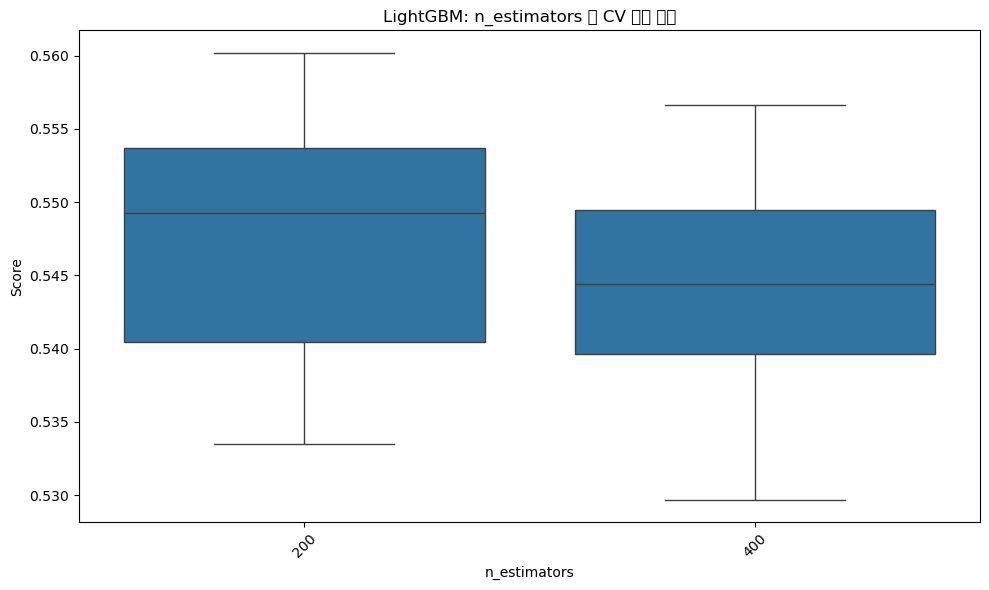

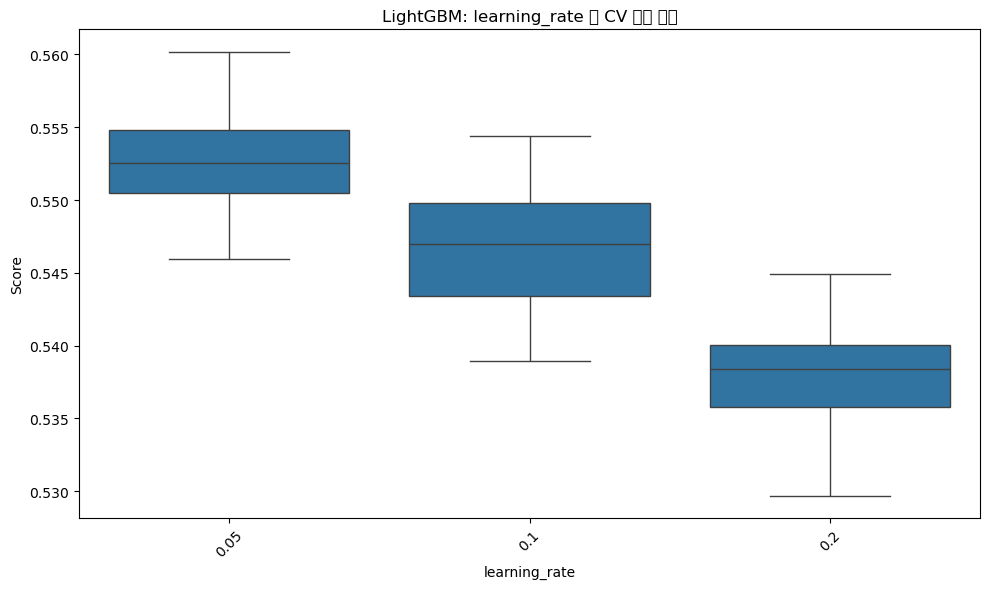

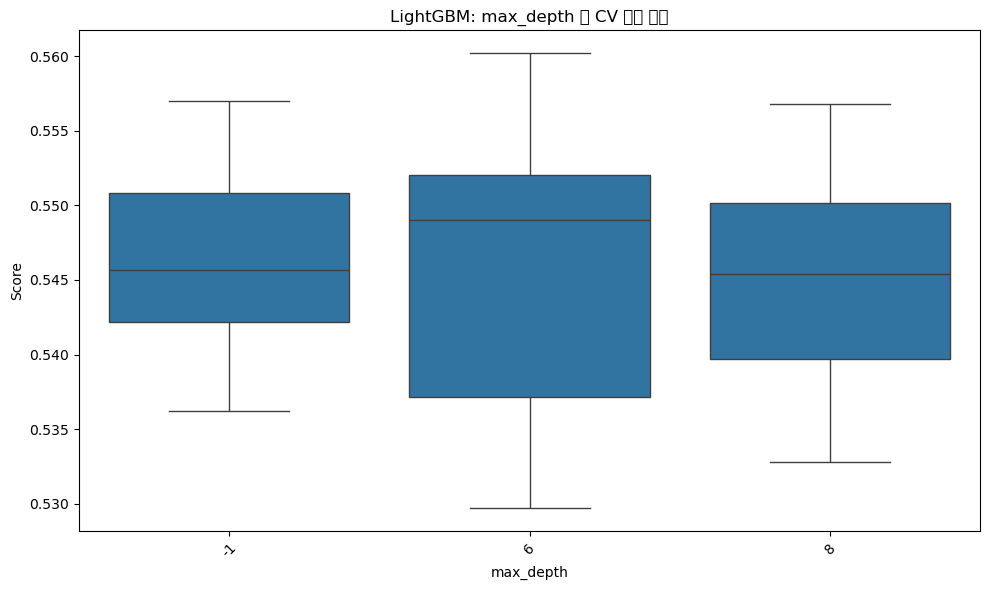

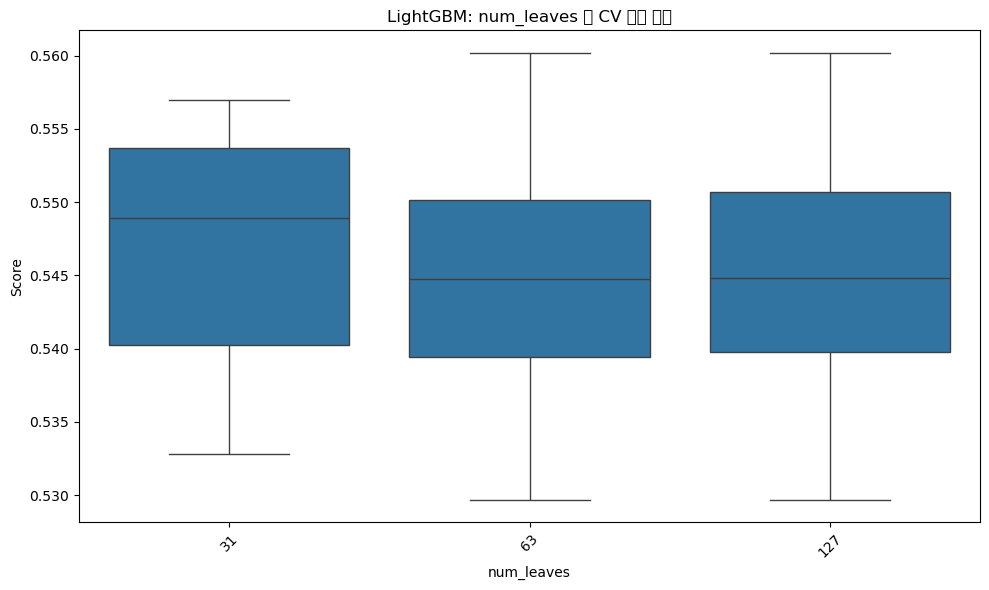

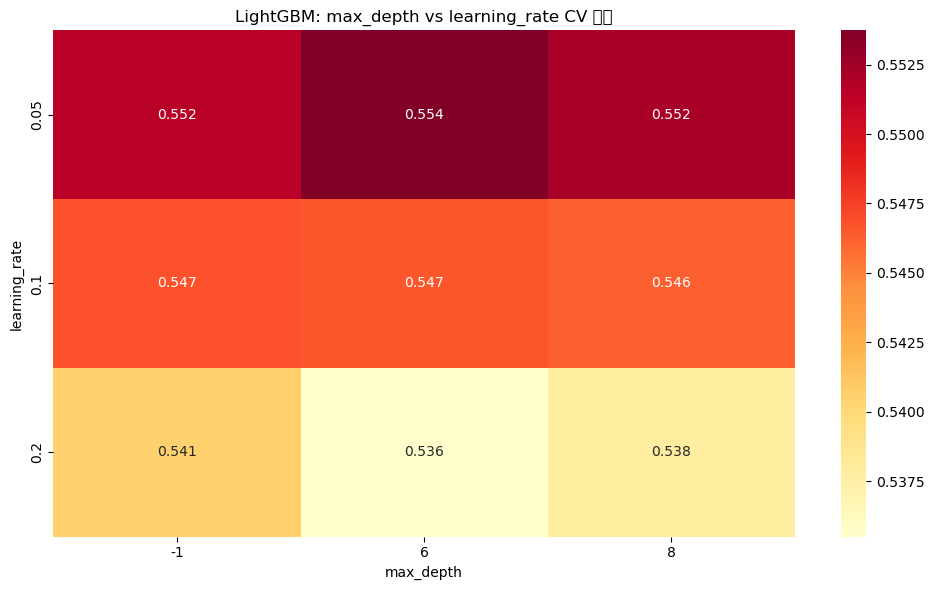

In [16]:
# === 6.2 LightGBM 파라미터 시각화 (저장된 lgb_results 재사용) ===
import pandas as pd
lgb_scores_df = pd.DataFrame(lgb_results)

for param in ['n_estimators', 'learning_rate', 'max_depth', 'num_leaves']:
    plot_param_scores(lgb_scores_df, param, 'LightGBM')

pivot_table = lgb_scores_df.pivot_table(
    values='Score',
    index='learning_rate',
    columns='max_depth',
    aggfunc='mean'
)
plot_heatmap(pivot_table, 'max_depth', 'learning_rate', 'LightGBM')